In [3]:
# Import standard libraries
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
import pybedtools

# Custom libraries
import prelim_analysis as pa

In [12]:
# Reload modules in case of modifications
reload(pa)

<module 'prelim_analysis' from '/home/louiscam/projects/gpcr/code/preliminary_analysis/prelim_analysis_chromosome_level/prelim_analysis.py'>

# Data directories

In [5]:
# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# Directory of processed HiC
dir_processed_hic = '/home/louiscam/projects/gpcr/save/processed_hic_data_dir/'
# Directory for storing preliminary results
prelim_results_dir = '/home/louiscam/projects/gpcr/save/prelim_results_dir/'

In [6]:
# Specify directories and relevant information
cell_type = 'IMR90'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'

# Load adhesome data

In [7]:
adhesome_components_filename = dir_adhesome+'components.csv'
df_components = pa.load_adhesome_data(adhesome_components_filename)
# Print information
print('Number of components: '+str(len(df_components)))
print('Number of intrinsic components: '+str(len(df_components[df_components['FA']=='Intrinsic Proteins'])))
print('Number of associated components: '+str(len(df_components[df_components['FA']=='Associated Proteins'])))
df_components.head()

Number of components: 232
Number of intrinsic components: 150
Number of associated components: 82


,geneSymbol,geneID,proteinName,swisprotID,synonyms,functionalCategory,FA
0,ACTN1,87,Actinin,P12814,alpha-actinin,Actin regulation,Intrinsic Proteins
1,CFL1,1072,cofilin,P23528,CFL,Actin regulation,Intrinsic Proteins
2,CORO1B,57175,coronin 1B,Q9BR76,coronin-2,Actin regulation,Intrinsic Proteins
3,CTTN,2017,Cortactin,Q14247,"EMS1, Amplaxin",Actin regulation,Intrinsic Proteins
4,FLNA,2316,Filamin,P21333,"endothelial actin-binding protein, ABP-280, al...",Actin regulation,Intrinsic Proteins


In [8]:
# List of intrinsic components
intrinsic_comps = np.sort(df_components[df_components['FA']=='Intrinsic Proteins']['geneSymbol'].values)
print(intrinsic_comps[:5])
# List of associated components
associated_comps = np.sort(df_components[df_components['FA']=='Associated Proteins']['geneSymbol'].values)

['ABL1' 'ACTB' 'ACTN1' 'AGAP2' 'ARHGAP24']


# Position of genes on hg19 genome

Positions of known genes in the hg19 genome can be retrieved from the UCSC Table Browser (https://genome.ucsc.edu/cgi-bin/hgTables?hgsid=1021064011_ad33421UafMtn6fGrxiDQ2sACaMe&clade=mammal&org=Human&db=hg19&hgta_group=genes&hgta_track=knownGene&hgta_table=kgXref&hgta_regionType=genome&position=chr19%3A2%2C249%2C113-2%2C252%2C072&hgta_outputType=primaryTable&hgta_outFileName=chrom_hg19_loc) with the following keys:
- Clade: Mammal
- Genome: Human
- Assembly: Feb 2009 (GRCh37/hg19)
- Group: Genes and Gene Predictions
- Track: UCSC Genes
- Table: Known Genes OR Known Canonical (will select only the longest isoform for each gene)

The UCSC gene names can be matched with standard gene symbols using another table, accessible with the keys:
- Clade: Mammal
- Genome: Human
- Assembly: Feb 2009 (GRCh37/hg19)
- Group: Genes and Gene Predictions
- Track: UCSC Genes
- Table: kgXref


In [9]:
# Path to gene locations and gene names files
gene_locations_filename = dir_genome+'chrom_hg19.loc_canonical'
gene_id_filename = dir_genome+'chrom_hg19.name'
df_loc = pa.get_gene_locations(gene_locations_filename, gene_id_filename)
print(len(df_loc))
df_loc.head()

25959


,transcript,geneSymbol,#chrom,chromStart,chromEnd,clusterId,protein
30786,uc021ree.1,7SK,chr12,114942680,114942992,7071,uc021ree.1
15095,uc002qsd.4,A1BG,chr19,58858171,58864865,15924,uc002qsd.4
14204,uc002qsg.3,A1BG-AS1,chr19,58863335,58866549,15925,uc002qsg.3
3436,uc001jjj.3,A1CF,chr10,52559168,52645435,3274,uc001jjj.3
6250,uc001qvk.1,A2M,chr12,9220303,9268558,6062,uc001qvk.1


# Location of adhesome proteins

In [13]:
# Merge adhesome proteins dataframe with gene location dataframe
adhesome_loc_df = pa.get_adhesome_genes_location(df_components, df_loc)
print(len(adhesome_loc_df))
adhesome_loc_df.head()

Adhesome genes absent from UCSC genes: ['PPP2CA', 'ITGAW', 'GRLF1', 'DDEF1', 'SH3KBP1', 'SMPX', 'MSN', 'FLNA', 'JUB', 'ARHGEF6']
222


,gene,chrom,genoStart,genoEnd,geneLength
0,ACTN1,chr14,69340839,69446083,105244
1,CFL1,chr11,65622284,65626101,3817
2,CORO1B,chr11,67205517,67210983,5466
3,CTTN,chr11,70244611,70282690,38079
4,KEAP1,chr19,10596795,10614054,17259


In [14]:
# Specify start locus and end locus
adhesome_loc_df = pa.get_adhesome_genes_loci(adhesome_loc_df, resol)
adhesome_loc_df.head()

,gene,chrom,loci,genoStart,genoEnd,geneLength,startLocus_id,startLocus,startLocus_coverage,endLocus_id,endLocus,endLocus_coverage
0,ACTN1,chr14,278,69340839,69446083,105244,278,69500000,0.420976,278,69500000,0.420976
1,CFL1,chr11,263,65622284,65626101,3817,263,65750000,0.015268,263,65750000,0.015268
2,CORO1B,chr11,269,67205517,67210983,5466,269,67250000,0.021864,269,67250000,0.021864
3,CTTN,chr11,281,70244611,70282690,38079,281,70250000,0.021556,282,70500000,0.130760
3,CTTN,chr11,282,70244611,70282690,38079,281,70250000,0.021556,282,70500000,0.130760


# Check HiC interactions on pairs of chromosome

In [15]:
# Load pair of chromosomes
chr1 = 1
chr2 = 2

In [16]:
# Restrict adhesome dataframe to chr1 and chr2
adhesome_chr1_df = adhesome_loc_df.loc[adhesome_loc_df['chrom']=='chr'+str(chr1)]
adhesome_chr2_df = adhesome_loc_df.loc[adhesome_loc_df['chrom']=='chr'+str(chr2)]

In [17]:
# Load HiC data for this chromosome pair
processed_hic_filename = 'hic_'+'chr'+str(chr1)+'_'+'chr'+str(chr2)+'_norm1_filter3'+'.pkl'
hic_chpair_df = pickle.load(open(dir_processed_hic+processed_hic_filename, 'rb'))

In [18]:
# Restrict HiC data to loci corresponding to adhesome genes
adhesome_chr1_loci = adhesome_chr1_df['loci']*resol
adhesome_chr2_loci = adhesome_chr2_df['loci']*resol
hic_chpair_df_restrict = hic_chpair_df.loc[adhesome_chr1_loci,adhesome_chr2_loci]

In [19]:
nloci_chr1 = len(adhesome_chr1_df['loci'])
nloci_chr2 = len(adhesome_chr2_df['loci'])

In [20]:
# Restrict HiC data to random set of loci
np.random.seed(13)
random_chr1_loci = np.random.choice(hic_chpair_df.index.values, nloci_chr1)
random_chr2_loci = np.random.choice(hic_chpair_df.columns.values, nloci_chr2)
hic_chpair_df_random = hic_chpair_df.loc[random_chr1_loci,random_chr2_loci]

Mean across random loci = 0.6848291008259647
Mean across adhesome loci = 1.052355195732847


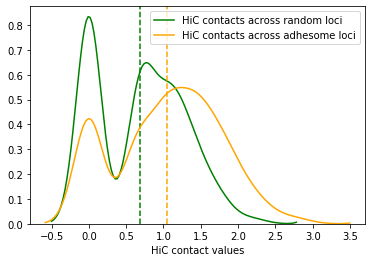

In [21]:
# Plot density plots of HiC contacts between adhesome proteins and between all proteins
plt.figure()
sns.distplot(hic_chpair_df_random.values.flatten(), 
             kde=True, hist=False, 
             color='green',
             axlabel='HiC contact values', label='HiC contacts across random loci')
plt.axvline(np.mean(hic_chpair_df_random.values.flatten()), color='green', linestyle='dashed')
print('Mean across random loci = '+str(np.mean(hic_chpair_df_random.values.flatten())))
sns.distplot(hic_chpair_df_restrict.values.flatten(), 
             kde=True, hist=False, 
             color='orange',
            label='HiC contacts across adhesome loci')
plt.axvline(np.mean(hic_chpair_df_restrict.values.flatten()), color='orange', linestyle='dashed')
print('Mean across adhesome loci = '+str(np.mean(hic_chpair_df_restrict.values.flatten())))
plotname = 'adhesome_random_hic_contacts_'+'chr'+str(chr1)+'_'+'chr'+str(chr2)+'.pdf'
#plt.savefig(prelim_results_dir+plotname, format='pdf')
plt.show()